In [1]:
# =============================================================
# [최종] 2차 모델 완벽 복제 전처리 함수 정의 셀
# =============================================================
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def run_preprocessing(df, imputer_path, scaler_path):
    """
    2차 모델의 MICE 임퓨터와 스케일러를 사용하여 데이터를 변환합니다.
    - base_features 순서 강제 재현 (ValueError 방지)
    - 파생 변수 수식 100% 일치 (+ 1 로직)
    """
    # 1. 도구 로드
    if not os.path.exists(imputer_path) or not os.path.exists(scaler_path):
        print("❌ 임퓨터나 스케일러 파일 경로를 확인해주세요.")
        return None, None
        
    with open(imputer_path, 'rb') as f:
        imputer = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 🌟 [2차 모델 학습 시의 피처 순서] 
    # 이 순서가 1픽셀이라도 틀리면 ValueError가 발생합니다.
    base_features = [
        'entry_age', 'PTGENDER', 'MH10GAST', 'MH11HEMA', 'MH12RENA', 'MH13ALLE', 
        'MH14ALCH', 'MH15DRUG', 'MH16SMOK', 'MH17MALI', 'MH18SURG', 'MH19OTHR', 
        'MH2NEURL', 'MH3HEAD', 'MH4CARD', 'MH5RESP', 'MH6HEPAT', 'MH7DERM', 
        'MH8MUSCL', 'MH9ENDO', 'MHPSYCH', 'COG_DISORDER', 'dementia_med', 
        'antidepressant_med', 'CDRSB', 'MMSCORE', 'FAQTOTAL', 'LDELTOTAL', 'VSBPSYS'
    ]

    # 🌟 [강제 정렬] CSV 원본 컬럼이 어떤 순서든, 임퓨터가 원하는 순서대로 재배치합니다.
    df_aligned = df.reindex(columns=base_features)
    
    # 2. MICE 결측치 대치
    print(f"✔️ MICE Imputer 적용 중...")
    df_imputed_raw = imputer.transform(df_aligned)
    df_imputed = pd.DataFrame(df_imputed_raw, columns=base_features)
    
    # 3. 파생 변수 생성 (2차 모델 학습 코드의 add_engineered_features와 100% 동일화)
    # 회원님의 요청대로 + 1 로직을 사용합니다.
    df_imputed['FAQ_LDELTA_ratio'] = df_imputed['FAQTOTAL'] / (df_imputed['LDELTOTAL'] + 1)
    df_imputed['high_risk_score']  = df_imputed['CDRSB'] * 2 + df_imputed['FAQTOTAL'] - df_imputed['LDELTOTAL']
    df_imputed['med_cog_risk']     = df_imputed['dementia_med'] + df_imputed['COG_DISORDER']
    df_imputed['CDRSB_MMSE_ratio'] = df_imputed['CDRSB'] / (df_imputed['MMSCORE'] + 1)
    df_imputed['cog_composite']    = df_imputed['MMSCORE'] - df_imputed['CDRSB'] * 2 - df_imputed['FAQTOTAL'] * 0.5
    
    # 🌟 [최종 스케일링 정렬] (HEALTH + COG + ENG 순서)
    COG_COLS = ['CDRSB', 'MMSCORE', 'FAQTOTAL', 'LDELTOTAL']
    ENG_FEATS = ['FAQ_LDELTA_ratio', 'high_risk_score', 'med_cog_risk', 'CDRSB_MMSE_ratio', 'cog_composite']
    HEALTH_COLS = [c for c in base_features if c not in COG_COLS]
    
    ALL_FEATS = HEALTH_COLS + COG_COLS + ENG_FEATS
    
    # 스케일러 적용
    X_scaled = scaler.transform(df_imputed[ALL_FEATS].values)
    
    return X_scaled, ALL_FEATS

print("✅ run_preprocessing 함수가 메모리에 성공적으로 로드되었습니다!")

✅ run_preprocessing 함수가 메모리에 성공적으로 로드되었습니다!


In [2]:
# 다음 셀에서 실행
PROJECT_DIR = '/Users/dudigi/project/test'
CSV_PATH = f'{PROJECT_DIR}/ADNI3_Golden_Master_Longitudinal_3.csv'
IMPUTER_PATH = f'{PROJECT_DIR}/stage2_mice_imputer.pkl'
SCALER_PATH = f'{PROJECT_DIR}/stage2_scaler.pkl'

df_raw = pd.read_csv(CSV_PATH)
# MCI, AD 환자만 필터링
df_binary = df_raw[df_raw['label_name'].isin(['MCI', 'AD'])].copy()

# 🌟 함수 호출
X_scaled, feat_list = run_preprocessing(df_binary, IMPUTER_PATH, SCALER_PATH)

if X_scaled is not None:
    print(f"🎉 성공! 전처리된 데이터 형태: {X_scaled.shape}")

✔️ MICE Imputer 적용 중...
🎉 성공! 전처리된 데이터 형태: (1042, 34)


🚀 [Step 3] 5-Seed 앙상블 모델 실전 검증 시작


2026-02-23 01:09:01.732327: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M5
2026-02-23 01:09:01.732341: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2026-02-23 01:09:01.732344: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2026-02-23 01:09:01.732354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-23 01:09:01.732361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-02-23 01:09:02.274777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


✔️ Seed 42 모델 예측 완료
✔️ Seed 123 모델 예측 완료
✔️ Seed 777 모델 예측 완료
✔️ Seed 2024 모델 예측 완료
✔️ Seed 99 모델 예측 완료

📊 [2차 앙상블 ANN] 최종 검증 리포트
              precision    recall  f1-score   support

         MCI       0.99      0.90      0.94       866
          AD       0.65      0.94      0.77       176

    accuracy                           0.90      1042
   macro avg       0.82      0.92      0.85      1042
weighted avg       0.93      0.90      0.91      1042

✔️ 최종 앙상블 AUC Score: 0.9753


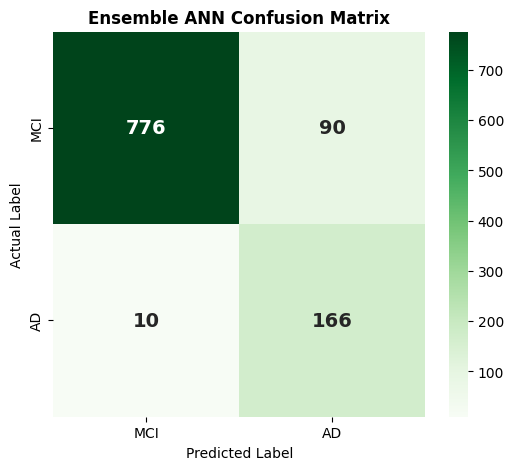


[🩺 MCI 환자 세부 위험도 분류 결과]
Risk
High Risk     40
Low Risk     682
Mid Risk     144
Name: count, dtype: int64


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("🚀 [Step 3] 5-Seed 앙상블 모델 실전 검증 시작")
print("=" * 60)

# 1. 모델 입력 슬라이싱 (25, 4, 5 구조)
X_h = X_scaled[:, :25]
X_c = X_scaled[:, 25:29]
X_e = X_scaled[:, 29:]

# 2. 5개 모델 로드 및 예측 확률 수집
SEEDS = [42, 123, 777, 2024, 99]
all_probs = []

for seed in SEEDS:
    model_path = f'/Users/dudigi/project/test/best_stage2_binary_ann_seed{seed}.keras'
    if os.path.exists(model_path):
        # 가중치가 학습된 모델 로드
        m = keras.models.load_model(model_path)
        # 확률값(P_AD) 추출
        p = m.predict([X_h, X_c, X_e], verbose=0).flatten()
        all_probs.append(p)
        print(f"✔️ Seed {seed} 모델 예측 완료")
    else:
        print(f"⚠️ Seed {seed} 모델 파일을 찾을 수 없습니다.")

# 3. Soft Voting (5개 확률의 평균)
ensemble_probs = np.mean(all_probs, axis=0)
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# 실제 정답 (MCI=0, AD=1)
y_true = df_binary['label_name'].map({'MCI': 0, 'AD': 1}).values

# 4. 종합 성적표 출력
print("\n" + "="*55)
print("📊 [2차 앙상블 ANN] 최종 검증 리포트")
print("="*55)
print(classification_report(y_true, ensemble_preds, target_names=['MCI', 'AD']))
print(f"✔️ 최종 앙상블 AUC Score: {roc_auc_score(y_true, ensemble_probs):.4f}")

# 5. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['MCI', 'AD'], yticklabels=['MCI', 'AD'],
            annot_kws={"size": 14, "weight": "bold"})
plt.title('Ensemble ANN Confusion Matrix', fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. MCI 환자 위험도(Risk) 분포 확인
df_binary['P_AD_score'] = ensemble_probs
mci_only = df_binary[df_binary['label_name'] == 'MCI'].copy()

def get_risk_tag(p):
    if p < 0.30: return 'Low Risk'
    elif p < 0.65: return 'Mid Risk'
    else: return 'High Risk'

mci_only['Risk'] = mci_only['P_AD_score'].apply(get_risk_tag)
print("\n[🩺 MCI 환자 세부 위험도 분류 결과]")
print(mci_only['Risk'].value_counts().sort_index())